In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [32]:
def adjustImage(frame, mode, contrastBool, threshBool,
                upperThresh, lowerThresh, contrast, brightness):
    if mode == 'HSV':
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        if contrastBool:
            hsv[:,:,2] = cv2.convertScaleAbs(hsv[:,:,2], alpha=contrast, beta=brightness)
        if threshBool:
            _, hsv[:,:,2] = cv2.threshold(hsv[:,:,2], lowerThresh, upperThresh, cv2.THRESH_BINARY)
        processed_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        processed_img = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
    elif mode == 'Gray':
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if contrastBool:
            gray = cv2.convertScaleAbs(gray, alpha=contrast, beta=brightness)
        if threshBool:
            _, gray = cv2.threshold(gray, lowerThresh, upperThresh, cv2.THRESH_BINARY)
        processed_img = gray
    else:
        raise ValueError("Mode should be 'HSV' or 'Gray'.")
    processed_img = cv2.resize(processed_img, (320, 240)) 
    return processed_img

Dimensions of the adjusted image: (2160, 3840)


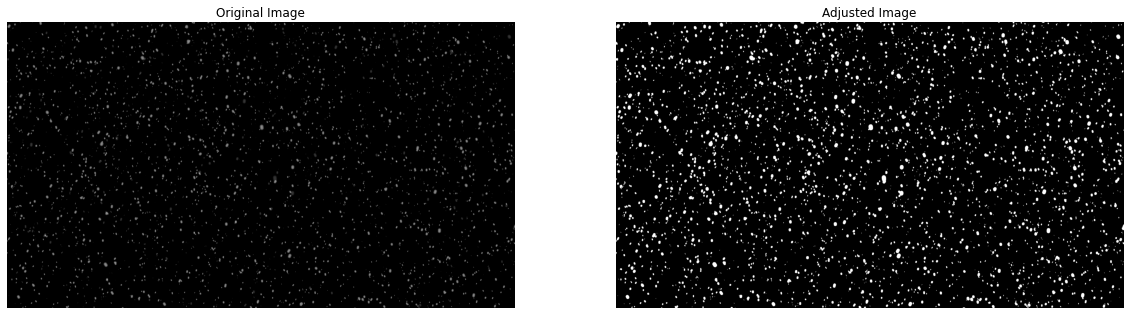

In [5]:
video_path = 'vecteezy_snow-falling-background_1623412.mp4'
mode = "Gray"
contrastBool = True
threshBool = True
lowerThresh = 59
upperThresh = 250
contrast = 2
brightness = 52

cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

adjusted_frame = adjustImage(frame, mode, contrastBool, threshBool,
                upperThresh, lowerThresh, contrast, brightness)

print("Dimensions of the adjusted image:", adjusted_frame.shape)

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# Create subplots for before and after comparison
plt.figure(figsize=(20, 12))

# Show the original image
plt.subplot(1, 2, 1)
plt.imshow(frame_rgb)
plt.title('Original Image')
plt.axis('off')

# Show the adjusted image
plt.subplot(1, 2, 2)
plt.imshow(adjusted_frame, cmap = 'gray')
plt.title('Adjusted Image')
plt.axis('off')

# Display the comparison
plt.show()

In [17]:
#Calculating FPS for timestep:
# Open the video file
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Failed to open video: {video_path}")
    exit()
# Get frames per second (FPS) of the video
fps = cap.get(cv2.CAP_PROP_FPS)

# Calculate the time (in seconds) between each frame
time_per_frame = 1 / fps

print(f"FPS: {fps}")

FPS: 29.97002997002997


Getting 64 by 32 dimensions (h x w)

- Had brightness 29 and Lower threshold 93, but when resizing the constrast wasn't strong enough. 
- Updated brightness to 52 and lower threshold to 59
- Upper Threshold and contrast are stable at 1 and 255 respectively

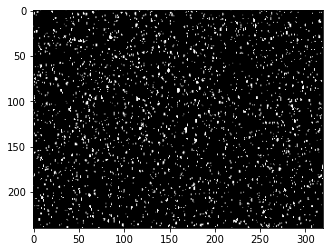

In [12]:
### RESIZE ONLY

resized_frame = cv2.resize(adjusted_frame, (320, 240))  # Note that width comes first in resize

plt.imshow(resized_frame, cmap = 'gray')

In [13]:
# # #FARNBACK OPTICAL FLOW METHOD
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"Failed to open video: {video_path}")
    exit()

ret, prev_frame = cap.read()
prev_frame = adjustImage(prev_frame, mode, contrastBool, threshBool, upperThresh, lowerThresh, contrast, brightness)
resized_prev_frame = cv2.resize(prev_frame, (320, 240)) 
ret, frame = cap.read()

current_frame = adjustImage(frame, mode, contrastBool, threshBool, upperThresh, lowerThresh, contrast, brightness)
resized_current_frame = cv2.resize(current_frame, (320, 240)) 

"""What is returned:
flow:
The result is a 2-channel array of the same size as the input images. Each pixel in the flow array contains a 2D vector that represents the displacement (motion) at that pixel in the horizontal and vertical directions:
flow[..., 0] contains the displacement in the x-direction (horizontal motion).
flow[..., 1] contains the displacement in the y-direction (vertical motion)."""

flow = cv2.calcOpticalFlowFarneback(resized_prev_frame, resized_current_frame, None, 0.5, 3, 15, 3, 5, 1.2, 0)

"""Pyr_scale (0.5): The scaling factor between image pyramids.
Levels (3): The number of pyramid layers.
Winsize (15): The averaging window size, which affects the smoothness of the flow.
Iterations (3): Number of iterations at each pyramid level.
Poly_n (5): Size of the pixel neighborhood for polynomial expansion.
Poly_sigma (1.2): Standard deviation of the Gaussian used to smooth derivatives.
Flags (0): Operation flags."""

'Pyr_scale (0.5): The scaling factor between image pyramids.\nLevels (3): The number of pyramid layers.\nWinsize (15): The averaging window size, which affects the smoothness of the flow.\nIterations (3): Number of iterations at each pyramid level.\nPoly_n (5): Size of the pixel neighborhood for polynomial expansion.\nPoly_sigma (1.2): Standard deviation of the Gaussian used to smooth derivatives.\nFlags (0): Operation flags.'

Stopped Here: Explor Farnebeck vs Lukas-Kanade, figure out resolution, try to run through algorithm :) <3

In [15]:
def visualize_flow(prev_frame,flow):
    hsv = np.zeros_like(prev_frame)  # Create an empty array with the same shape as the frame
    hsv = cv2.cvtColor(hsv, cv2.COLOR_GRAY2BGR)  # Convert to BGR for HSV

    # Calculate the magnitude and angle of the flow vectors
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Set the hue to the direction of the flow
    hsv[..., 0] = angle * 180 / np.pi / 2  # Scale angle to be in 0-180 range

    # Set the saturation to the normalized magnitude of the flow
    hsv[..., 1] = 255

    # Set the value to the magnitude of the flow
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

    # Convert HSV to BGR for display
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Display the flow
    plt.figure(figsize=(20, 12))
    plt.imshow(flow_bgr)
    plt.axis('off')
    plt.show()


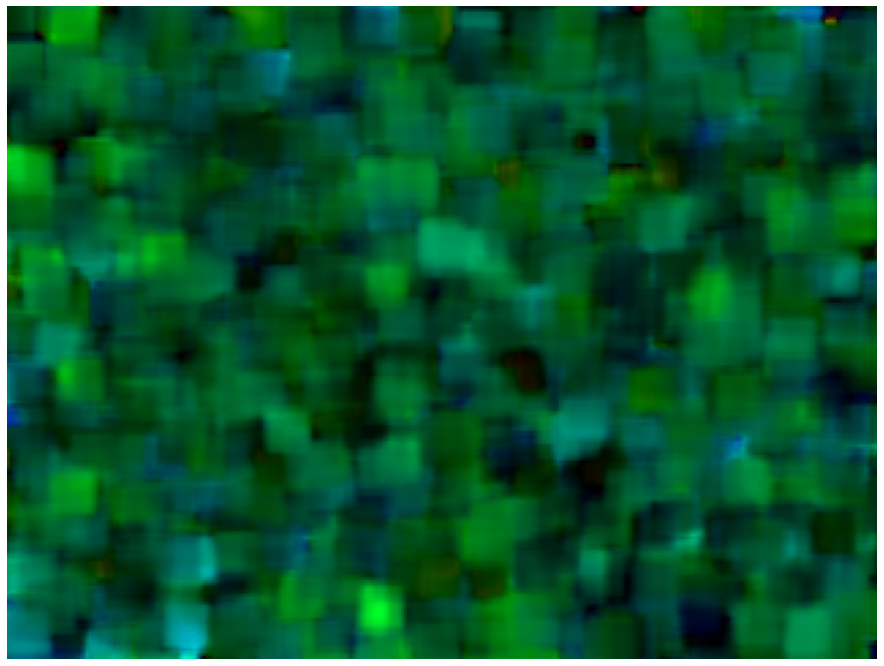

In [16]:
"""Explanation:
The cv2.cartToPolar function is used to convert the flow vectors into magnitude (flow speed) and angle (flow direction).

Hue (H):

The hue corresponds to the direction of movement in the optical flow.
The hue value ranges from 0 to 180 degrees, which represents different angles in a 2D plane:

0° (red) typically corresponds to motion to the right.
90° (green) typically corresponds to motion downwards.
180° (blue/cyan) typically corresponds to motion to the left.
270° (yellow/magenta) typically corresponds to motion upwards.

This allows you to visually interpret the direction of motion in the frame by the color.

Saturation (S):

The saturation indicates the magnitude of the flow (strength or intensity of the motion).
Higher saturation means faster motion, and lower saturation means slower motion.

Value (V):

The value typically represents the brightness, which is often mapped to the magnitude of the flow in normalized form.

Magnitude and Angle Calculation:
"""

visualize_flow(resized_prev_frame,flow)

In [34]:
def extract_and_compute_flows(video_path, mode, contrastBool, threshBool, upperThresh, lowerThresh, contrast, brightness):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Failed to open video: {video_path}")
        return None, None  # Avoid using exit()

    vector_data = []
    vector_labels = []

    frames = []
    frame_count = 0

    # Read and preprocess frames
    while True:
        ret, frame = cap.read()
        print("Read the frame: " + str(frame_count))
        if not ret or frame_count >= 20:  # Stop reading after 100 frames
            break
        
        frame = adjustImage(frame, mode, contrastBool, threshBool, upperThresh, lowerThresh, contrast, brightness)
        frames.append(frame)
        frame_count += 1
    
        # Ensure we have at least 10 frames before processing
        if len(frames) >= 10:
            for i in range(5):
                # Ensure we have enough frames for current flow calculations
                if len(frames) > i + 9:
                    # Compute flow between i-th and (i+4)-th frames
                    flow_data = cv2.calcOpticalFlowFarneback(frames[i], frames[i + 4], None, 0.5, 3, 15, 3, 5, 1.2, 0)
                    vector_data.append(flow_data)

                    # Compute flow between (i+5)-th and (i+9)-th frames for future prediction
                    flow_label = cv2.calcOpticalFlowFarneback(frames[i + 5], frames[i + 9], None, 0.5, 3, 15, 3, 5, 1.2, 0)
                    vector_labels.append(flow_label)

            # Remove the first frame and continue processing
            frames.pop(0)

    cap.release()

    # # Convert lists to numpy arrays, then to tensors
    # vector_data_tensor = torch.tensor(np.array(vector_data))
    # vector_labels_tensor = torch.tensor(np.array(vector_labels))

    # return vector_data_tensor, vector_labels_tensor

    return vector_data, vector_labels


In [35]:
data, labels = extract_and_compute_flows(video_path, mode, contrastBool, threshBool, upperThresh, lowerThresh, contrast, brightness)

Read the frame: 0
Read the frame: 1
Read the frame: 2
Read the frame: 3
Read the frame: 4
Read the frame: 5
Read the frame: 6
Read the frame: 7
Read the frame: 8
Read the frame: 9
Read the frame: 10
Read the frame: 11
Read the frame: 12
Read the frame: 13
Read the frame: 14
Read the frame: 15
Read the frame: 16
Read the frame: 17
Read the frame: 18
Read the frame: 19
Read the frame: 20


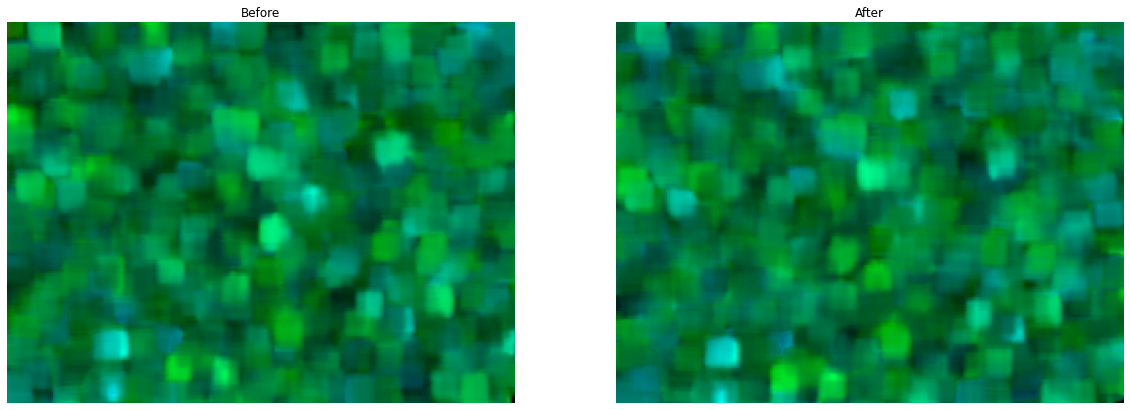

In [40]:
def visualize_comparison_flow(prev_frame, flow, ax, title):
    """
    Visualize optical flow using HSV color mapping.
    
    Args:
    prev_frame (np.ndarray): Previous frame from the video (grayscale).
    flow (np.ndarray): Optical flow array containing flow vectors (x, y).
    ax (matplotlib.axes._subplots.AxesSubplot): The axis to plot on.
    title (str): Title for the plot.
    """
    hsv = np.zeros_like(prev_frame)  # Create an empty array with the same shape as the frame
    hsv = cv2.cvtColor(hsv, cv2.COLOR_GRAY2BGR)  # Convert to BGR for HSV

    # Calculate the magnitude and angle of the flow vectors
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Set the hue to the direction of the flow
    hsv[..., 0] = angle * 180 / np.pi / 2  # Scale angle to be in 0-180 range

    # Set the saturation to the normalized magnitude of the flow
    hsv[..., 1] = 255

    # Set the value to the magnitude of the flow
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

    # Convert HSV to BGR for display
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Display the flow on the given axis
    ax.imshow(flow_bgr)
    ax.set_title(title)
    ax.axis('off')

prev_frame_example = np.random.randint(0, 255, (240, 320), dtype=np.uint8) 
flow_before = data[0]  # Optical flow before
flow_after = labels[0]  # Optical flow after

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(20, 12))

# Visualize the flows
visualize_comparison_flow(prev_frame_example, flow_before, axs[0], "Before")
visualize_comparison_flow(prev_frame_example, flow_after, axs[1], "After")

In [ ]:
data = data.permute(0, 3, 1, 2)  # [n_samples, 2, height, width]
labels = labels.permute(0, 3, 1, 2)

# Take a smaller portion of the dataset (otherwise it's 5 GB...)
num_samples = data.shape[0] // 11

data = data[:num_samples]
labels = labels[:num_samples]